In [1]:
# Question 1 – Futures Pricing under the Two-Factor Model

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

# Load Dataset (for plotting)
df = pd.read_excel("Dataset_FuturesPrices.xlsx", sheet_name=0)
maturities_labels = df.iloc[0, 0:5].values
observed_prices = df.iloc[1, 0:5].astype(float).values
log_observed_prices = df.iloc[1, 6:11].astype(float).values
maturities_years = np.array([int(label.split()[0]) / 12 for label in maturities_labels])

# Parameters from Kalman Filter
kappa = 1.3784
sigma_chi = 0.2894
sigma_xi = 0.1476
rho = 0.3
mu_star = 0.0089   # risk-neutral drift
r = 0.05

chi_0 = 0.215304
xi_0 = 2.96002749
S0 = np.exp(chi_0 + xi_0)  # ≈ 19.3
K = np.exp(xi_0)           # strike aligned with Q2/Q3

# Futures Pricing Function
def futures_price(tau, chi, xi, kappa, sigma_chi, sigma_xi, rho, mu_star):
    exp_decay = np.exp(-kappa * tau)
    E_lnS = exp_decay * chi + xi + mu_star * tau
    Var_lnS = (
        (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * tau))
        + sigma_xi**2 * tau
        + 2 * rho * sigma_chi * sigma_xi * (1 - exp_decay) / kappa
    )
    lnF = E_lnS + 0.5 * Var_lnS
    return np.exp(lnF)

# Black-Implied Volatility
def futures_vol(tau, kappa, sigma_chi, sigma_xi, rho):
    var_lnF = (
        (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * tau))
        + sigma_xi**2 * tau
        + 2 * rho * sigma_chi * sigma_xi * (1 - np.exp(-kappa * tau)) / kappa
    )
    return np.sqrt(var_lnF / tau)

# Black Formula for Option Pricing
def black_option_price(F, K, T, sigma, r, option='call'):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    df = np.exp(-r * T)
    if option == 'call':
        return df * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        return df * (K * norm.cdf(-d2) - F * norm.cdf(-d1))


# Option Pricing with Black Formula
T = 1.0  # maturity in years

F = futures_price(T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_star)
sigma_black = futures_vol(T, kappa, sigma_chi, sigma_xi, rho)
call_price = black_option_price(F, K, T, sigma_black, r, option='call')

print(f" Futures price at T={T}y: {F:.4f}")
print(f" Black implied volatility: {sigma_black:.4f}")
print(f" Call option price (Black formula): €{call_price:.4f}")

 Futures price at T=1.0y: 21.2266
 Black implied volatility: 0.2533
 Call option price (Black formula): €2.9941


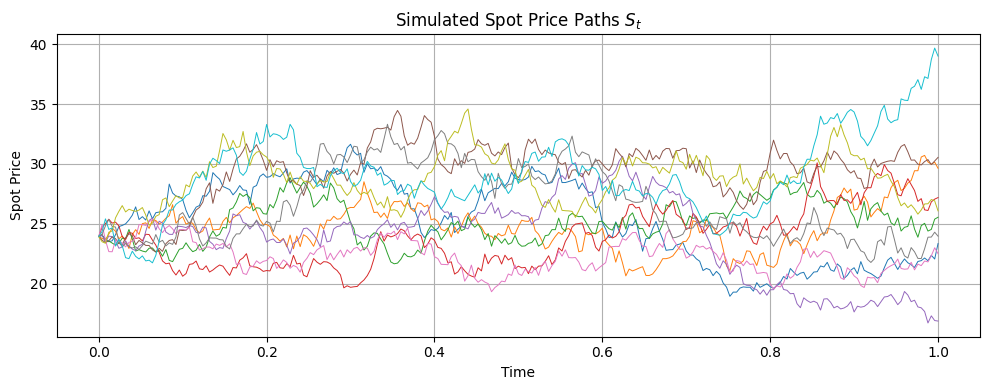

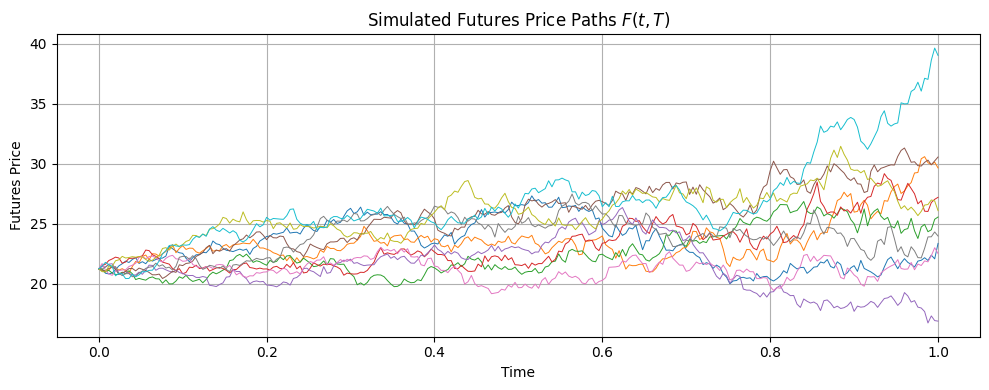

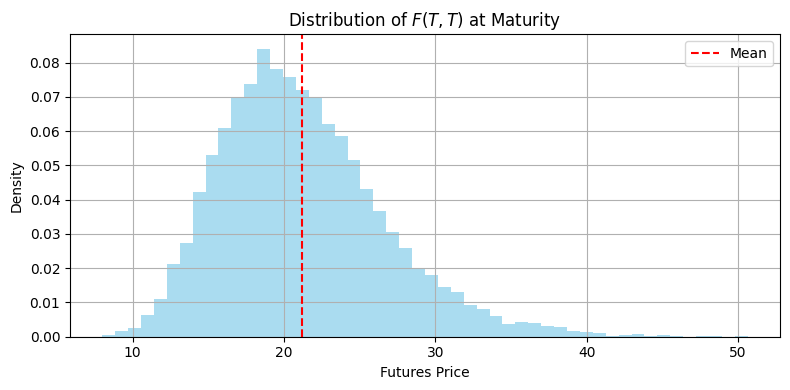

🎯 Monte Carlo Call Option Price: €2.9790


In [2]:
# Question 2

# Simulate Two-Factor Model (Euler Scheme)
def simulate_factors(chi0, xi0, kappa, sigma_chi, sigma_xi, rho, mu_star, T, N, M, seed=None):
    dt = T / N
    t = np.linspace(0, T, N + 1)
    chi = np.zeros((M, N + 1))
    xi = np.zeros((M, N + 1))
    chi[:, 0] = chi0
    xi[:, 0] = xi0

    if seed:
        np.random.seed(seed)
    L = np.linalg.cholesky([[1, rho], [rho, 1]])

    for i in range(1, N + 1):
        Z = np.random.randn(2, M)
        dW = L @ Z
        chi[:, i] = chi[:, i-1] - kappa * chi[:, i-1] * dt + sigma_chi * np.sqrt(dt) * dW[0]
        xi[:, i]  = xi[:, i-1] + mu_star * dt + sigma_xi * np.sqrt(dt) * dW[1]

    return t, chi, xi

# Monte Carlo Option Pricing on Futures
def mc_option_price_on_futures(chi0, xi0, kappa, sigma_chi, sigma_xi, rho, mu_star,
                               T, N, K, r, M=10000, seed=None, option='call', plot=False):
    t, chi, xi = simulate_factors(chi0, xi0, kappa, sigma_chi, sigma_xi, rho, mu_star, T, N, M, seed)
    tau_grid = T - t  # τ = T - tᵢ
    F = np.zeros_like(chi)
    for i in range(N + 1):
        F[:, i] = futures_price(tau_grid[i], chi[:, i], xi[:, i], kappa, sigma_chi, sigma_xi, rho, mu_star)

    F_T = F[:, -1]

    # Option Payoff
    if option == 'call':
        payoff = np.maximum(F_T - K, 0)
    else:
        payoff = np.maximum(K - F_T, 0)
    
    price = np.exp(-r * T) * np.mean(payoff)

    # Optional plots
    if plot:
        plt.figure(figsize=(10, 4))
        for i in range(min(10, M)):
            plt.plot(t, np.exp(chi[i] + xi[i]), lw=0.7)
        plt.title("Simulated Spot Price Paths $S_t$")
        plt.xlabel("Time")
        plt.ylabel("Spot Price")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 4))
        for i in range(min(10, M)):
            plt.plot(t, F[i], lw=0.7)
        plt.title("Simulated Futures Price Paths $F(t,T)$")
        plt.xlabel("Time")
        plt.ylabel("Futures Price")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.hist(F_T, bins=50, density=True, alpha=0.7, color='skyblue')
        plt.axvline(np.mean(F_T), color='red', linestyle='--', label='Mean')
        plt.title("Distribution of $F(T,T)$ at Maturity")
        plt.xlabel("Futures Price")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return price

# Run Monte Carlo with Calibrated Parameters

# Parameters from Kalmann Filter
kappa = 1.3784
sigma_chi = 0.2894
sigma_xi = 0.1476
rho = 0.3
mu_star = 0.0089
r = 0.05
chi_0 = 0.215304
xi_0 = 2.96002749
T = 1.0
K = np.exp(xi_0)  # Same strike as Question 1
N = 250
M = 10000

call_mc_price = mc_option_price_on_futures(chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_star,
                                            T, N, K, r, M=M, seed=42, option='call', plot=True)

print(f"🎯 Monte Carlo Call Option Price: €{call_mc_price:.4f}")

 Futures price (used as S₀): 21.2266
 Call price via characteristic function: €2.9941


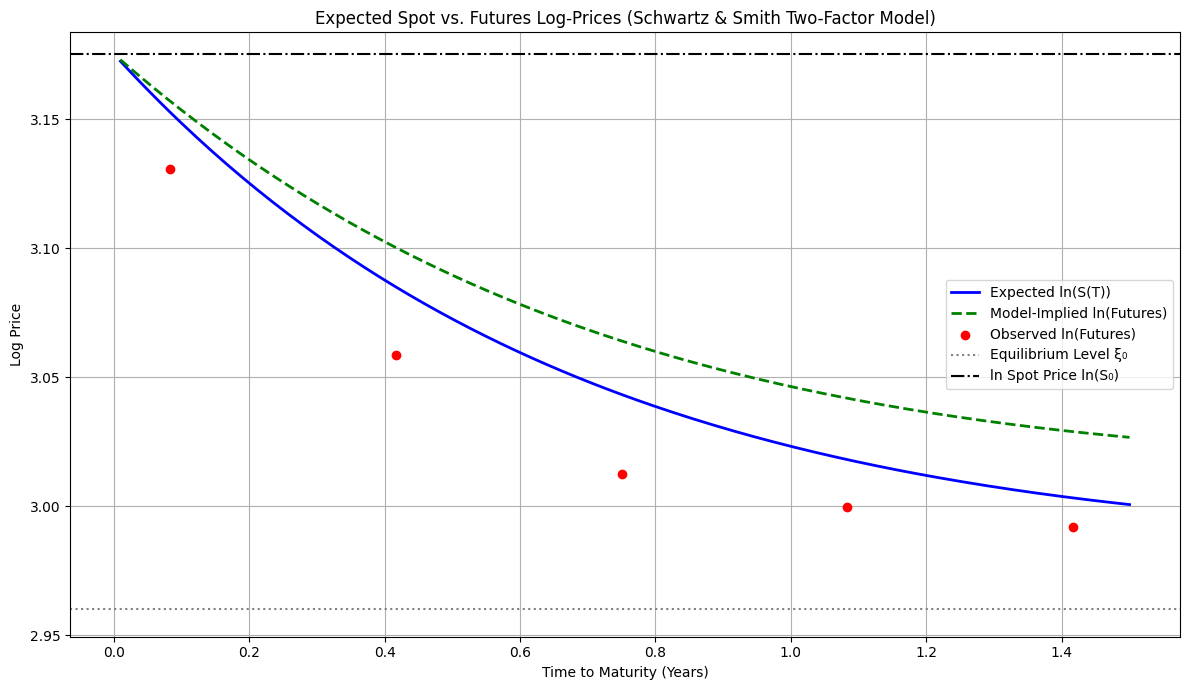

In [3]:
# Question 3 – Option Pricing via CF (with S₀ = Futures)

import numpy as np
from scipy.integrate import fixed_quad
from scipy.stats import norm

# Parameters from Kalman Filter
kappa = 1.3784
sigma_chi = 0.2894
sigma_xi = 0.1476
rho = 0.3
mu_star = 0.0089   # risk-neutral drift (mu*)
r = 0.05
chi_0 = 0.215304
xi_0 = 2.96002749
T = 1.0
K = np.exp(xi_0)

# Futures price as the equivalent spot
def futures_price(tau, chi, xi, kappa, sigma_chi, sigma_xi, rho, mu_star):
    exp_decay = np.exp(-kappa * tau)
    E_lnS = exp_decay * chi + xi + mu_star * tau
    Var_lnS = (
        (sigma_chi**2)/(2*kappa)*(1 - np.exp(-2*kappa*tau))
        + sigma_xi**2 * tau
        + 2 * rho * sigma_chi * sigma_xi * (1 - exp_decay) / kappa
    )
    lnF = E_lnS + 0.5 * Var_lnS
    return np.exp(lnF)

F0 = futures_price(T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_star)

# Characteristic function of ln(S(T))
def char_func_lnST(u, T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_star):
    m = xi_0 + mu_star * T + chi_0 * np.exp(-kappa * T)
    v = (sigma_xi**2 * T +
         sigma_chi**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * T)) +
         2 * rho * sigma_xi * sigma_chi / kappa * (1 - np.exp(-kappa * T)))
    return np.exp(1j * u * m - 0.5 * u**2 * v)

φ = lambda u: char_func_lnST(u, T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho, mu_star)

# Integration for π₁ and π₂
def integrand_pi1(u):
    numerator = np.exp(-1j * u * np.log(K)) * φ(u - 1j)
    denominator = 1j * u * φ(-1j)
    return np.real(numerator / denominator)

def integrand_pi2(u):
    numerator = np.exp(-1j * u * np.log(K)) * φ(u)
    denominator = 1j * u
    return np.real(numerator / denominator)

pi1_integral, _ = fixed_quad(integrand_pi1, 0, 20, n=32)
pi2_integral, _ = fixed_quad(integrand_pi2, 0, 20, n=32)

pi1 = 0.5 + (1 / np.pi) * pi1_integral
pi2 = 0.5 + (1 / np.pi) * pi2_integral

# Option Price via CF
call_cf = np.exp(-r * T) * (F0 * pi1 - K * pi2)

print(f" Futures price (used as S₀): {F0:.4f}")
print(f" Call price via characteristic function: €{call_cf:.4f}")

# Plot: Expected ln(S(T)) vs ln(Futures)

def expected_log_spot_price(T, chi_0, xi_0, kappa, mu_star):
    return chi_0 * np.exp(-kappa * T) + xi_0 + mu_star * T

def futures_log_price(T, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho):
    term1 = xi_0 + chi_0 * np.exp(-kappa * T)
    var_chi = (sigma_chi**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * T))
    var_xi = sigma_xi**2 * T
    cov = 2 * rho * sigma_chi * sigma_xi / kappa * (1 - np.exp(-kappa * T))
    return term1 + 0.5 * (var_chi + var_xi + cov)

T_grid = np.linspace(0.01, 1.5, 200)
expected_lnS = expected_log_spot_price(T_grid, chi_0, xi_0, kappa, mu_star)
model_lnF = futures_log_price(T_grid, chi_0, xi_0, kappa, sigma_chi, sigma_xi, rho)
ln_S0 = chi_0 + xi_0

plt.figure(figsize=(12, 7))
plt.plot(T_grid, expected_lnS, label="Expected ln(S(T))", color='blue', lw=2)
plt.plot(T_grid, model_lnF, label="Model-Implied ln(Futures)", color='green', lw=2, linestyle='--')
plt.scatter(maturities_years, log_observed_prices, color='red', label="Observed ln(Futures)", zorder=5)
plt.axhline(xi_0, color='gray', linestyle=':', label='Equilibrium Level ξ₀')
plt.axhline(ln_S0, color='black', linestyle='-.', label='ln Spot Price ln(S₀)')

plt.title("Expected Spot vs. Futures Log-Prices (Schwartz & Smith Two-Factor Model)")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Log Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [4]:
# Question 4

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from typing_extensions import Annotated, Literal
from typing import List

# Load your Excel dataset
df = pd.read_excel("Dataset_FuturesPrices.xlsx",
                   sheet_name="FuturesPrices",
                   nrows=270,
                   usecols="A:E",
                   header=1,
                   )

df.columns = ['1M', '5M', '9M', '13M', '17M']
df
# Assume columns are named '1M', '5M', '9M', '13M', '17M'
# Log-transform the futures prices
log_futures = np.log(df[['1M', '5M', '9M', '13M', '17M']].values)

# Check the shape of the data
print("Log futures prices shape:", log_futures.shape)

# Define maturities in months
maturities_months = [1, 5, 9, 13, 17]

# --- Parameter Calculation Functions ---

def build_F_matrix(kappa, maturities_months):
    """
    Build the observation matrix F_t based on maturities and kappa.
    """
    tau = np.array(maturities_months) / 12  # Convert to years
    A = np.exp(-kappa * tau)
    F_t = np.column_stack([A, np.ones(len(tau))])  # [e^(-kappa * tau), 1]
    return F_t

def compute_transition_matrix(kappa, dt):
    """
    Compute the transition matrix G.
    """
    phi = np.exp(-kappa * dt)
    G = np.array([[phi, 0],
                  [0, 1]])
    return G

def compute_process_noise_covariance(dt, kappa, sigma_chi, sigma_xi, rho):
    """
    Compute the process noise covariance matrix W(t) based on the paper.

    Parameters:
    - t: Time (absolute, in years).
    - kappa: Mean-reversion rate of chi_t.
    - sigma_chi: Volatility of the short-term factor chi_t.
    - sigma_xi: Volatility of the long-term factor xi_t.
    - rho: Correlation between chi_t and xi_t.

    Returns:
    - W: 2x2 covariance matrix.
    """
    W_11 = (1 - np.exp(-2 * kappa * dt)) * (sigma_chi**2 / (2 * kappa))
    W_12 = (1 - np.exp(-kappa * dt)) * (rho * sigma_chi * sigma_xi / kappa)
    W_22 = sigma_xi**2 * dt

    W = np.array([
        [W_11, W_12],
        [W_12, W_22]
    ])
    return W

def compute_deterministic_vector(mu_xi, dt):
    """
    Compute the deterministic vector c.
    """
    c = np.array([0, mu_xi * dt])
    return c

def compute_A(T, mu_star_xi, lambda_chi, kappa, sigma_chi, sigma_xi, rho):
    """
    Compute the deterministic term A(T) for a given maturity T.
    """
    drift_term = mu_star_xi * T
    risk_premium_term = -(1 - np.exp(-kappa * T)) * (lambda_chi / kappa)
    variance_term_1 = (1 - np.exp(-2 * kappa * T)) * (sigma_chi**2 / (2 * kappa))
    variance_term_2 = sigma_xi**2 * T
    covariance_term = (1 - np.exp(-kappa * T)) * (rho * sigma_chi * sigma_xi / kappa)
    A_T = drift_term + risk_premium_term + 0.5 * (variance_term_1 + variance_term_2) + covariance_term

    return A_T



# --- Kalman Filter Implementation ---

# def kalman_filter(y, kappa, sigma_chi, sigma_xi, rho, R_stds, mu_xi, lambda_chi, mu_star_xi, x0=None, P0=None, compute_likelihood=True):
def kalman_filter(y: np.ndarray,
                  kappa: float,
                  sigma_chi: float,
                  sigma_xi: float,
                  rho: float,
                  R_stds: Annotated[List[float], Literal[5]],
                  mu_xi: float,
                  lambda_chi: float,
                  mu_star_xi: float,
                  x0=None,
                  P0=None):
    """
    Kalman filter implementation using precomputed parameters.
    """

    assert len(R_stds) == 5, "R_stds must contain exactly 5 values (for 5 maturities)"
    n_obs, n_maturities = y.shape
    dt = 1 / 52  # Time step in years (daily data)

    # Precompute deterministic vector c
    c = compute_deterministic_vector(mu_xi, dt)

    # Initial state
    x_filtered = np.zeros((n_obs, 2))  # Store filtered states [chi_t, xi_t]
    x_pred = x0 if x0 is not None else np.zeros(2)  # Initial state mean
    P = P0 if P0 is not None else np.eye(2)  # Initial state covariance

    # Measurement noise covariance V
      # Ensure R_stds is a 1D array

    V = np.diag(np.array(R_stds**2))


    # Storage for log-likelihood components

    innovations = []
    innovation_covariances = []


    yhats = []

    for t_idx in range(n_obs):
        # Compute time-dependent parameters

        G = compute_transition_matrix(kappa, dt)
        W = compute_process_noise_covariance(dt, kappa, sigma_chi, sigma_xi, rho)
        F_t = build_F_matrix(kappa, maturities_months)

        # Compute deterministic term d_t
        d_t = np.array([compute_A(T / 12, mu_star_xi, lambda_chi, kappa, sigma_chi, sigma_xi, rho) for T in maturities_months])

        # Prediction step
        x_pred = c + G @ x_pred  # a_t = c + G * m_{t-1}
        P = G @ P @ G.T + W      # R_t = G * C_{t-1} * G.T + W

        # Observation
        y_t = y[t_idx]

        # Innovation
        y_hat = d_t + F_t @ x_pred  # f_t = d_t + F_t * a_t
        innovation = y_t - y_hat    # y_t - f_t
        S = F_t @ P @ F_t.T + V     # Q_t = F_t * R_t * F_t.T + V

        # Store log-likelihood components

        innovations.append(innovation)
        innovation_covariances.append(S)


        yhats.append(y_hat)

        # Kalman Gain
        A_t = P @ F_t.T @ np.linalg.inv(S)  # A_t = R_t * F_t.T * Q_t^-1

        # Update step
        x_pred = x_pred + A_t @ innovation  # m_t = a_t + A_t * (y_t - f_t)
        P = P - A_t @ F_t @ P               # C_t = R_t - A_t * Q_t * A_t.T

        # Store filtered state
        x_filtered[t_idx] = x_pred


    return x_filtered, innovations, innovation_covariances, yhats


# --- Negative Log-Likelihood ---

def negative_log_likelihood(params, y):
    """
    Compute the negative log-likelihood for parameter estimation.
    """
    # Unpack parameters
    n_maturities = y.shape[1]
    assert n_maturities == 5, "This implementation expects 5 maturities"
    kappa, sigma_chi, sigma_xi, rho = params[:4]
    R_stds = np.array(params[4:4+n_maturities])
    mu_xi = params[4 + n_maturities]
    lambda_chi = params[5 + n_maturities]
    mu_star_xi = params[6 + n_maturities]

    # Run the Kalman filter with likelihood computation enabled
    _, innovations, innovation_covariances, _ = kalman_filter(
        y, kappa, sigma_chi, sigma_xi, rho, R_stds, mu_xi, lambda_chi, mu_star_xi
    )

    # Compute log-likelihood
    log_likelihood = 0
    n_maturities = y.shape[1]

    for innovation, S in zip(innovations, innovation_covariances):
        sign, logdet = np.linalg.slogdet(S)
        log_likelihood += -0.5 * (
                logdet +
                innovation.T @ np.linalg.inv(S) @ innovation +
                n_maturities * np.log(2 * np.pi)
            )
        if sign != 1:
            return np.inf

    # Return negative log-likelihood
    return -log_likelihood




    # for innovation, S in zip(innovations, innovation_covariances):
    #     try:
    #         log_likelihood += -0.5 * (
    #             np.log(np.linalg.det(S)) +
    #             innovation.T @ np.linalg.inv(S) @ innovation +
    #             n_maturities * np.log(2 * np.pi)
    #         )
    #     except np.linalg.LinAlgError:
    #         return np.inf

    # # Return negative log-likelihood
    # return -log_likelihood

# --- Parameter Estimation ---

# Initial parameter guesses

initial_params = [0.5, 0.2, 0.1, 0.3, 0.05, 0.05, 0.05, 0.05, 0.05, 0.02, 0.01, 0.03] # Add initial guesses for lambda_chi and lambda_xi

# Bounds for parameters
bounds = [(0.01, 2), (0.01, 1), (0.01, 1), (-0.3, 0.3)] + [(0.01, 0.5)] * 5 + [(-1, 1), (-1, 1), (-1, 1)]
# Optimize
result = minimize(negative_log_likelihood, initial_params, args=(log_futures,), bounds=bounds)
print("Estimated parameters:", result.x)

kappa = result.x[0]
sigma_chi = result.x[1]
sigma_xi = result.x[2]
rho = result.x[3]
R_stds = result.x[4:9]
mu_xi = result.x[9]
lambda_chi = result.x[10]
mu_star_xi = result.x[11]

# Display results
print("\n--- Estimated Parameters ---")
print(f"kappa (mean reversion rate): {kappa:.4f}")
print(f"sigma_chi (short-term vol): {sigma_chi:.4f}")
print(f"sigma_xi (equilibrium vol): {sigma_xi:.4f}")
print(f"rho (correlation): {rho:.4f}")
print("R_stds (measurement errors):", np.round(R_stds, 5))
print(f"mu_xi (equilibrium drift): {mu_xi:.4f}")
print(f"lambda_chi (risk premium): {lambda_chi:.4f}")
print(f"mu_star_xi (risk-neutral drift): {mu_star_xi:.4f}")

Log futures prices shape: (268, 5)
Estimated parameters: [ 1.37842867  0.28939501  0.14758956  0.3         0.03626059  0.01
  0.01        0.01        0.01       -0.01983379  0.05671914  0.00888583]

--- Estimated Parameters ---
kappa (mean reversion rate): 1.3784
sigma_chi (short-term vol): 0.2894
sigma_xi (equilibrium vol): 0.1476
rho (correlation): 0.3000
R_stds (measurement errors): [0.03626 0.01    0.01    0.01    0.01   ]
mu_xi (equilibrium drift): -0.0198
lambda_chi (risk premium): 0.0567
mu_star_xi (risk-neutral drift): 0.0089


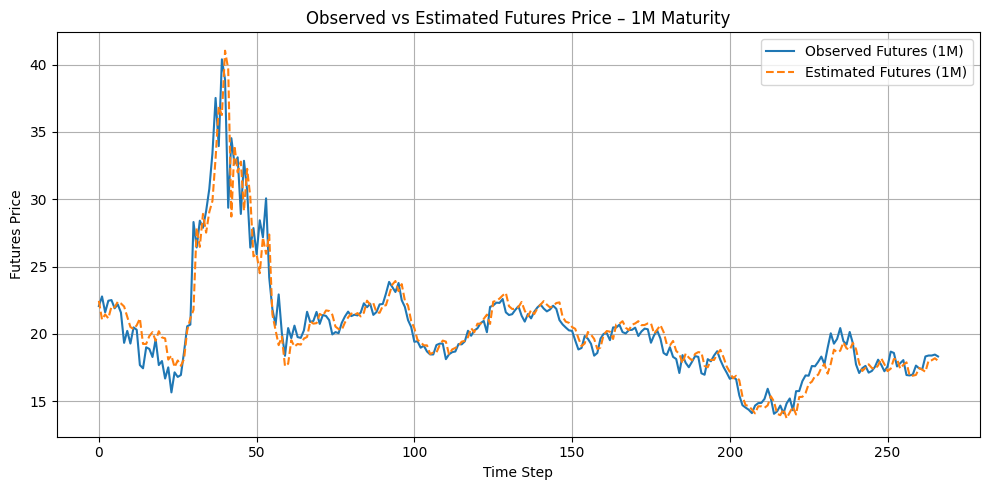


--- Estimated Parameters ---
kappa (mean reversion rate): 1.3784
sigma_chi (short-term vol): 0.2894
sigma_xi (equilibrium vol): 0.1476
rho (correlation): 0.3000
R_stds (measurement errors): [0.03626 0.01    0.01    0.01    0.01   ]
mu_xi (equilibrium drift): -0.0198
lambda_chi (risk premium): 0.0567
mu_star_xi (risk-neutral drift): 0.0089
GBM log-likelihood: -2835.3972017026895
OU log-likelihood: -3206.312791417214
Log-Likelihoods:
S&S 2-Factor: 3585.80
GBM (xi_t only): 2835.40
OU (chi_t only): 3206.31


In [ ]:

# Guillaume : Retrieve the estimated price (log-futures) by desactivating the mode log-likelihood
_, _, _, y_hat_preds = kalman_filter(
    log_futures,
    kappa,
    sigma_chi,
    sigma_xi,
    rho,
    R_stds,
    mu_xi,
    lambda_chi,
    mu_star_xi,
)

# Convert log-price in real price
futures_observed = np.exp(log_futures)  # Raw data
futures_estimated = np.exp(np.array(y_hat_preds))  # Estimated by the model


plt.figure(figsize=(10, 5))
plt.plot(futures_observed[1:, 0], label='Observed Futures (1M)')
plt.plot(futures_estimated[1:, 0], label='Estimated Futures (1M)', linestyle='--')
plt.title('Observed vs Estimated Futures Price – 1M Maturity')
plt.xlabel('Time Step')
plt.ylabel('Futures Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Define parameter names
kappa = result.x[0]
sigma_chi = result.x[1]
sigma_xi = result.x[2]
rho = result.x[3]
R_stds = result.x[4:9]
mu_xi = result.x[9]
lambda_chi = result.x[10]
mu_star_xi = result.x[11]

# Display results
print("\n--- Estimated Parameters ---")
print(f"kappa (mean reversion rate): {kappa:.4f}")
print(f"sigma_chi (short-term vol): {sigma_chi:.4f}")
print(f"sigma_xi (equilibrium vol): {sigma_xi:.4f}")
print(f"rho (correlation): {rho:.4f}")
print("R_stds (measurement errors):", np.round(R_stds, 5))
print(f"mu_xi (equilibrium drift): {mu_xi:.4f}")
print(f"lambda_chi (risk premium): {lambda_chi:.4f}")
print(f"mu_star_xi (risk-neutral drift): {mu_star_xi:.4f}")

def negative_log_likelihood_gbm(free_params, y):
    """
    Log-likelihood for GBM (only long-term xi_t).
    sigma_chi = 0, lambda_chi = 0, rho = 0
    """
    # Unpack parameters
    sigma_xi = free_params[0]
    R_stds = free_params[1:6]
    mu_xi = free_params[6]
    mu_star_xi = free_params[7]

    # Fixed parameters
    kappa = 0.5  # Arbitrary, not used
    sigma_chi = 0.0
    rho = 0.0
    lambda_chi = 0.0

    # Combine into full param list
    full_params = [kappa, sigma_chi, sigma_xi, rho] + list(R_stds) + [mu_xi, lambda_chi, mu_star_xi]

    return negative_log_likelihood(full_params, y)


initial_gbm = [0.1] + [0.05]*5 + [0.01, 0.01]  # [sigma_xi, R_stds (5), mu_xi, mu_star_xi]
bounds_gbm = [(0.001, 1)] + [(0.001, 0.5)]*5 + [(-1, 1), (-1, 1)]

result_gbm = minimize(negative_log_likelihood_gbm, initial_gbm, args=(log_futures,), bounds=bounds_gbm)
print("GBM log-likelihood:", result_gbm.fun)


def negative_log_likelihood_ou(free_params, y):
    """
    Log-likelihood for OU process (only short-term chi_t).
    sigma_xi = 0, mu_xi = 0, mu_star_xi = 0
    """
    # Unpack parameters
    kappa = free_params[0]
    sigma_chi = free_params[1]
    rho = free_params[2]
    R_stds = free_params[3:8]
    lambda_chi = free_params[8]

    # Fixed parameters
    sigma_xi = 0.0
    mu_xi = 0.0
    mu_star_xi = 0.0

    # Combine into full param list
    full_params = [kappa, sigma_chi, sigma_xi, rho] + list(R_stds) + [mu_xi, lambda_chi, mu_star_xi]

    return negative_log_likelihood(full_params, y)

initial_ou = [0.5, 0.1, 0.0] + [0.05]*5 + [0.01]  # [kappa, sigma_chi, rho, R_stds (5), lambda_chi]
bounds_ou = [(0.01, 2), (0.001, 1), (-0.99, 0.99)] + [(0.001, 0.5)]*5 + [(-1, 1)]

result_ou = minimize(negative_log_likelihood_ou, initial_ou, args=(log_futures,), bounds=bounds_ou)
print("OU log-likelihood:", result_ou.fun)




In [6]:
print(f"Log-Likelihoods:")
print(f"S&S 2-Factor: {-result.fun:.2f}")
print(f"GBM (xi_t only): {-result_gbm.fun:.2f}")
print(f"OU (chi_t only): {-result_ou.fun:.2f}")

Log-Likelihoods:
S&S 2-Factor: 3585.80
GBM (xi_t only): 2835.40
OU (chi_t only): 3206.31
